# ML-Leaks Adversary 3

## Imports

In [1]:
import sys 
import numpy as np 
import matplotlib.pyplot as plt


import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

sys.path.insert(0, '../src_code')

import models
from train import *
from metrics import * 

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Python: 3.6.5 (default, Jun 21 2018, 23:07:39) 
[GCC 5.4.0 20160609]
Pytorch: 0.4.0


## Hyperparameters

In [2]:
n_epochs = 10
batch_size = 256
lr = 0.001



## Load CIFAR10

Files already downloaded and verified
Files already downloaded and verified


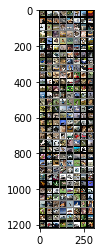

In [3]:
# define series of transforms to pre process images 
transform = torchvision.transforms.Compose([
    # have to pad a few pixels for resnet
    torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


# load training set 
cifar10_trainset = torchvision.datasets.CIFAR10('../datasets/', train=True, transform=transform, download=True)
cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# load test set 
cifar10_testset = torchvision.datasets.CIFAR10('../datasets/', train=False, transform=transform, download=True)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=100, shuffle=False, num_workers=2)

# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs,labels = iter(cifar10_trainloader).next()
imshow(torchvision.utils.make_grid(imgs))  

## ML Leaks Adversary 3 (Membership Inference Attack) 
### https://arxiv.org/abs/1806.01246

In [4]:

total_size = len(cifar10_trainset)


indices = list(range(total_size))

split = total_size // 2
target_train_idx = indices[:split]
target_out_idx = indices[split:]



target_train_sampler = SubsetRandomSampler(target_train_idx)
target_out_sampler = SubsetRandomSampler(target_out_idx)

target_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_train_sampler, num_workers=1)
target_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_out_sampler, num_workers=1)



# the model being attacked (architecture can be different than shadow)
target_net = torchvision.models.resnet18(num_classes=10).to(device)
target_net.avgpool = nn.AvgPool2d(2, stride=1)
#target_net = models.mlleaks_cnn().to(device)

target_net.apply(models.weights_init)

target_loss = nn.CrossEntropyLoss()
target_optim = optim.Adam(target_net.parameters(), lr=lr)





In [5]:
train(target_net, target_train_loader, cifar10_testloader, target_optim, target_loss, n_epochs, classes=classes)


[0/10]
Accuracy of airplane : 71.80 %
Accuracy of automobile : 64.30 %
Accuracy of bird : 68.70 %
Accuracy of cat : 9.90 %
Accuracy of deer : 43.30 %
Accuracy of dog : 41.20 %
Accuracy of frog : 56.90 %
Accuracy of horse : 64.50 %
Accuracy of ship : 55.20 %
Accuracy of truck : 61.40 %

Total accuracy = 53.72 %


[1/10]
Accuracy of airplane : 53.60 %
Accuracy of automobile : 83.60 %
Accuracy of bird : 29.10 %
Accuracy of cat : 19.20 %
Accuracy of deer : 41.00 %
Accuracy of dog : 63.20 %
Accuracy of frog : 61.00 %
Accuracy of horse : 49.00 %
Accuracy of ship : 80.50 %
Accuracy of truck : 67.60 %

Total accuracy = 54.78 %


[2/10]
Accuracy of airplane : 76.20 %
Accuracy of automobile : 72.80 %
Accuracy of bird : 28.20 %
Accuracy of cat : 44.10 %
Accuracy of deer : 43.30 %
Accuracy of dog : 65.30 %
Accuracy of frog : 75.60 %
Accuracy of horse : 77.90 %
Accuracy of ship : 67.50 %
Accuracy of truck : 71.50 %

Total accuracy = 62.24 %


[3/10]
Accuracy of airplane : 76.30 %
Accuracy of automo

threshold = 0.5000, accuracy = 51.86, precision = 0.51, recall = 0.98
threshold = 0.5050, accuracy = 51.99, precision = 0.51, recall = 0.98
threshold = 0.5100, accuracy = 52.09, precision = 0.51, recall = 0.98
threshold = 0.5150, accuracy = 52.19, precision = 0.51, recall = 0.98
threshold = 0.5200, accuracy = 52.27, precision = 0.51, recall = 0.98
threshold = 0.5250, accuracy = 52.33, precision = 0.51, recall = 0.98
threshold = 0.5300, accuracy = 52.45, precision = 0.51, recall = 0.98
threshold = 0.5350, accuracy = 52.53, precision = 0.51, recall = 0.97
threshold = 0.5400, accuracy = 52.60, precision = 0.51, recall = 0.97
threshold = 0.5450, accuracy = 52.67, precision = 0.51, recall = 0.97
threshold = 0.5500, accuracy = 52.81, precision = 0.51, recall = 0.97
threshold = 0.5550, accuracy = 52.87, precision = 0.52, recall = 0.97
threshold = 0.5600, accuracy = 52.97, precision = 0.52, recall = 0.97
threshold = 0.5650, accuracy = 53.08, precision = 0.52, recall = 0.96
threshold = 0.5700, 

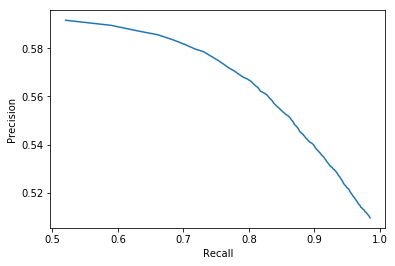

In [6]:
eval_membership_inference(target_net, target_train_loader, target_out_loader)